In [124]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

In [125]:
# Hàm lấy đường dẫn
def get_dir_path(n : int):
    '''
    n : 0 : current dir
    n : 1 : parent dir
    n : 2 : parent's parent dir
    '''
    path = os.getcwd()
    
    for _ in range(n):
        path = os.path.dirname(path)
    
    return path

In [126]:
path = get_dir_path(1)

# Đường dẫn đến thư mục chứa ảnh
# images_folder = os.path.join(path, 'Data', 'images')
images_folder = os.path.join(path, 'Data', 'image_test')

images_folder

'f:\\Code\\auto_ViVQA\\Data\\image_test'

In [127]:
# Hàm lấy tất cả các định dạng file trong thư mục
def get_all_file_extensions(folder_path):
    """
    Get all file extensions in a folder
    """
    extensions = set()
    
    for file_name in os.listdir(folder_path):
        _, ext = os.path.splitext(file_name)
        
        if ext:
            #Normalize the extension
            extensions.add(ext.lower())
    
    return extensions

In [128]:
# Find all extensions
extensions = get_all_file_extensions(images_folder)

print(extensions)

{'.jpg'}


Đây là hàm duyệt qua các ảnh, để tìm kích thước ảnh nào là phố biến nhất. Sau đó resize lại các ảnh khác theo cùng kích thước đó

In [129]:
def find_most_common_image_size(folder_path, extension=".jpg"):
    """
    Find the most common image size in a folder with a specific extension.
    :param 
        folder_path: Path to the folder containing images
        extension: File extension to filter images (default is .jpg)
    :return: 
        Tuple of (height, width) of the most common image size
    """
    size_counter = Counter()
    image_files = [f for f in os.listdir(folder_path) if f.endswith(extension)]

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_path)

        if img is not None:
            h, w = img.shape[:2]
            size_counter[(w, h)] += 1
        else:
            print(f"[ERROR] Could not read {image_file}")

        if (idx + 1) % 1000 == 0 or (idx + 1) == len(image_files):
            print(f"Scanned {idx + 1}/{len(image_files)} images")

    most_common = size_counter.most_common(1)
    if most_common:
        (w, h), count = most_common[0]
        print(f"\nKích thước phổ biến nhất: ({h}x{w}) - {count} ảnh")
        return (h, w)
    else:
        print("Không tìm thấy ảnh hợp lệ.")
        return None


In [130]:
target_size = find_most_common_image_size(images_folder, extension=".jpg")

Scanned 10/10 images

Kích thước phổ biến nhất: (480x640) - 4 ảnh


## Các hàm tiền xử lý ảnh

Đây là file ảnh để test các hàm tiền xử lý ảnh

In [131]:
# TEST
# image = cv2.imread("F:\\Code\\auto_ViVQA\\Data\\water.jpg")
image = cv2.imread("C:\\Users\\Admin\\Downloads\\actor-adult-dark-emotion.jpg")



### 0. Sharpening

In [132]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

# Dùng ảnh mẫu từ skimage
# image = data.camera().astype(np.float32) / 255.0

* Công thức sharpen
$$
sharpened = original + amount × (original - blurred)
$$
$$
sharpened = Original * (1 + amount) + Blurred * (-amount)
$$

Dưới đây là 2 cách code nhưng cùng 1 ý tưởng. Tuy nhiên theo thực nghiệm thì thấy cách 1 tốt hơn

In [133]:
# Cách 1

def unsharp_mask(image, amount=1.5):
    # Làm mờ ảnh với Gaussian blur
    blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=2)

    # Thực hiện Unsharp Masking
    unsharp = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)
    return unsharp

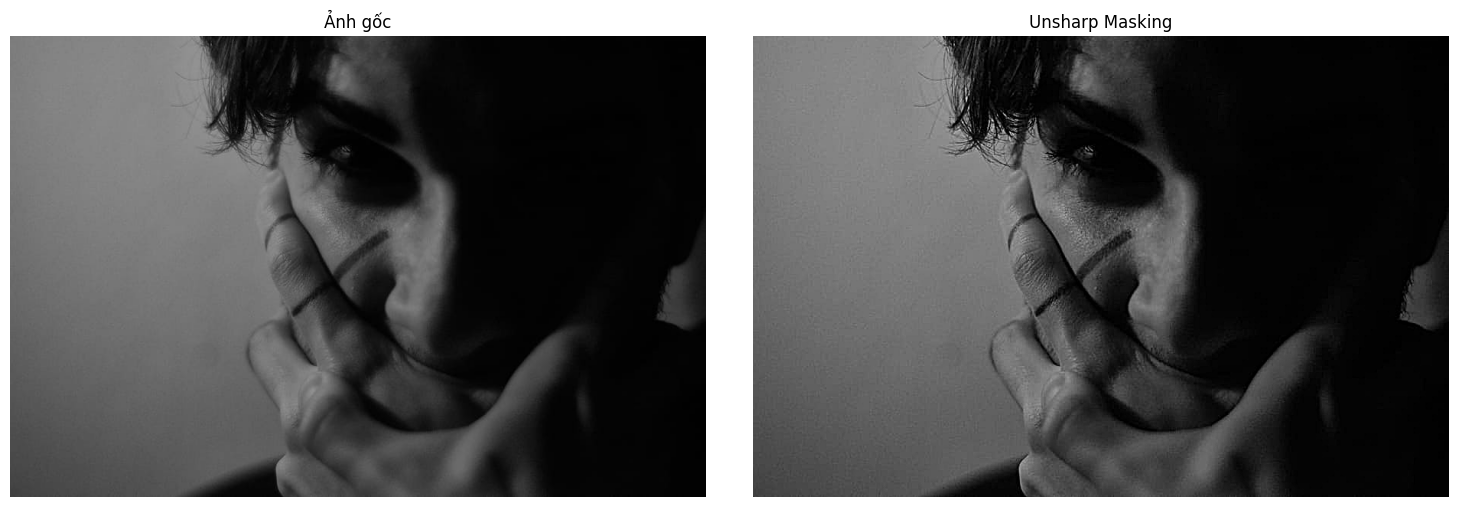

In [134]:
# TEST
unsharp = unsharp_mask(image)
# Hiển thị kết quả
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
titles = ['Ảnh gốc', 'Unsharp Masking']
images = [image, unsharp]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

Link tham khảo: [Sharpening An Image using OpenCV Library in Python](https://www.analyticsvidhya.com/blog/2021/08/sharpening-an-image-using-opencv-library-in-python/)

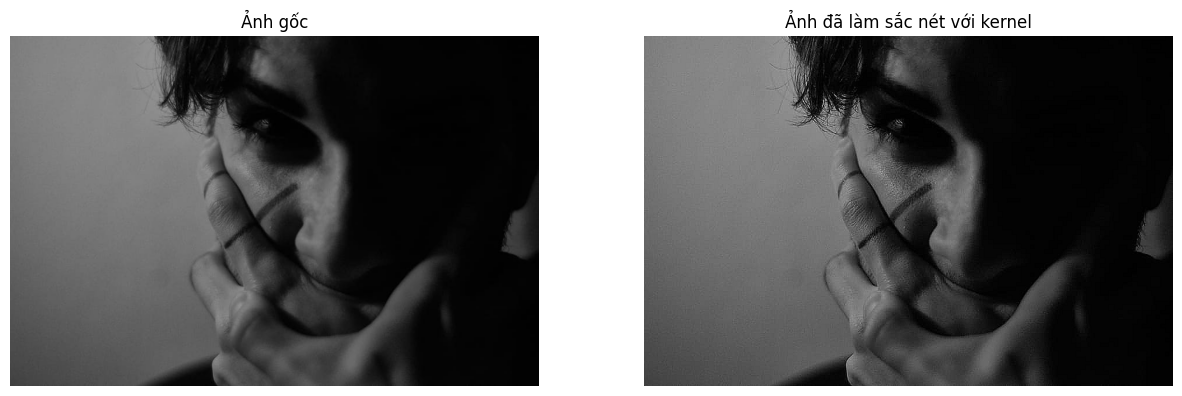

In [135]:
# Cách 2: Sử dụng kernel
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

image_sharpened = cv2.filter2D(image, -1, kernel)

# cv2.imshow('AV CV- Winter Wonder Sharpened', image_sharpened)
# cv2.waitKey()
# cv2.destroyAllWindows()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Ảnh gốc')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_sharpened, cv2.COLOR_BGR2RGB))
plt.title('Ảnh đã làm sắc nét với kernel')
plt.axis('off')
plt.show()

### 1. Điều chỉnh kích thước ảnh

Ta sẽ tiến hành resize ảnh theo tỷ lệ để tránh bóp méo vật. Ta sẽ thêm padding màu đen vào phần còn lại của bức ảnh để đảm bảo đạt được kích thước mong muốn. Lý do chọn padding màu đen là vì màu đen có giá trị pixel = 0 nên sẽ ít gây nhiễu hoặc gây ảnh hưởng đến đến các phép toán convolution trong CNN ( tuyến tính hoặc gần tuyến tính)

Đã được chứng minh padding màu đen là tốt nhất trong bài báo sau: [link](https://link.springer.com/article/10.1007/s11263-024-02069-9)

In [136]:
def resize_image(image, target_size):
    """
    Resize an image to fit within the target size while maintaining aspect ratio.
    If the resized image does not match the target size, it will be padded with black borders.
    :param 
        image: Input image as a numpy array.
        target_size: Tuple (height, width) specifying the target size.
    :return:
        Resized and padded image as a numpy array.
    """
    old_size = image.shape[:2]  # (height, width)
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))  # (width, height)
    
    # Resize
    resized_image = cv2.resize(image, new_size)

    # Get the padding amounts
    delta_w = target_size[1] - new_size[0]
    delta_h = target_size[0] - new_size[1]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    # Add padding
    color = [0, 0, 0]  # Black
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

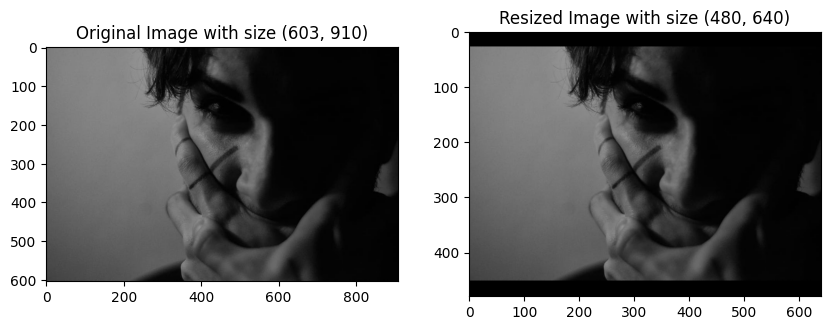

In [137]:
# TEST
if image is not None:
    resized_image = resize_image(image, target_size)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with size {}".format(image.shape[:2]))

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Resized Image with size {target_size}")
    plt.show()

### 2. Xử lý nhiễu trong ảnh

| Tham số                | Ý nghĩa                                                                               |
| ---------------------- | ------------------------------------------------------------------------------------- |
| `image`                | Ảnh đầu vào (RGB, dạng NumPy array)                                                   |
| `None`                 | Không cần ảnh đích đầu ra (OpenCV sẽ tự tạo)                                          |
| `h`                 | Hệ số lọc nhiễu cho kênh độ sáng (luminance) — càng cao thì càng làm mờ mạnh          |
| `hColor`            | Hệ số lọc nhiễu cho kênh màu (chrominance)                                            |
| `templateWindowSize=7` | Kích thước cửa sổ mẫu (patch) dùng để so sánh — thường là 7 hoặc 9                    |
| `searchWindowSize=21`  | Kích thước vùng tìm kiếm patch tương tự — lớn hơn sẽ khử nhiễu tốt hơn nhưng chậm hơn |


In [138]:
def denoise_image(image):
    """
    Denoise the image using Non-Local Means Denoising
    """
    denoised_image = cv2.fastNlMeansDenoisingColored(image, dst=None, h=3, hColor=3, templateWindowSize=7, searchWindowSize=21)

    return denoised_image

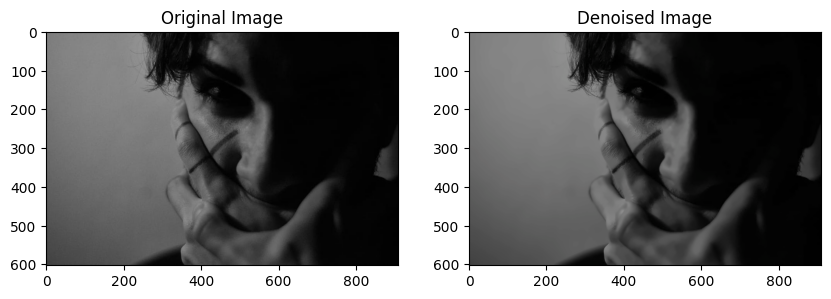

In [139]:
# TEST
if image is not None:
    denoised_image = denoise_image(image)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Denoised Image")
    plt.show()

### 3. Color correction (Adaptive Histogram Equalization)

Link bài viết về phương pháp: [link](https://pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/)

Không gian màu LAB là gì?

`LAB` là một không gian màu phi tuyến tính, được thiết kế để gần với cách **mắt người cảm nhận màu sắc**.

🔹 Cấu trúc gồm 3 kênh:

| Kênh | Ý nghĩa                                   | Phạm vi giá trị        |
| ---- | ----------------------------------------- | ---------------------- |
| `L`  | Lightness – độ sáng (0: đen → 100: trắng) | 0 – 255 (trong OpenCV) |
| `A`  | Màu từ xanh lá → đỏ                       | 0 – 255                |
| `B`  | Màu từ xanh dương → vàng                  | 0 – 255                |

> Kênh `L` quyết định độ sáng, còn `A` và `B` mang thông tin màu sắc.
>
> Với ảnh đen trắng thì `A` và `B` sẽ không có gì

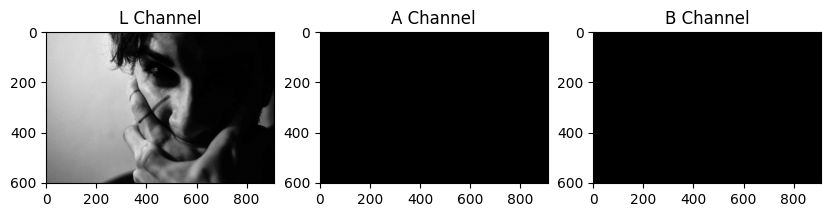

In [140]:
# TEST
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
l_channel, a_channel, b_channel = cv2.split(lab_image)
if image is not None:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(l_channel, cmap='gray')
    plt.title("L Channel")

    plt.subplot(1, 3, 2)
    plt.imshow(a_channel, cmap='gray')
    plt.title("A Channel")

    plt.subplot(1, 3, 3)
    plt.imshow(b_channel, cmap='gray')
    plt.title("B Channel")
    plt.show()

In [141]:
def apply_clahe_color(img):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel of an image in LAB color space.
    :param 
        img: Input image in BGR format.
    :return: 
        Image with enhanced contrast in BGR format.
    """
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)

    lab_eq = cv2.merge((l_eq, a, b))
    img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    return img_eq

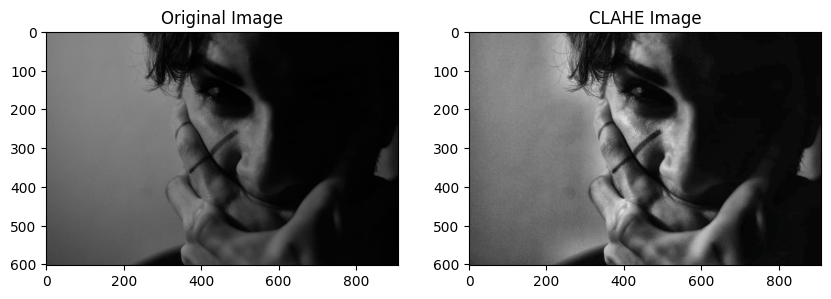

In [142]:
# TEST
if image is not None:
    clahe_image = apply_clahe_color(image)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB))
    plt.title("CLAHE Image")
    plt.show()

### Thực nghiệm thứ tự các bước trong pipeline để tìm thứ tự tốt nhất

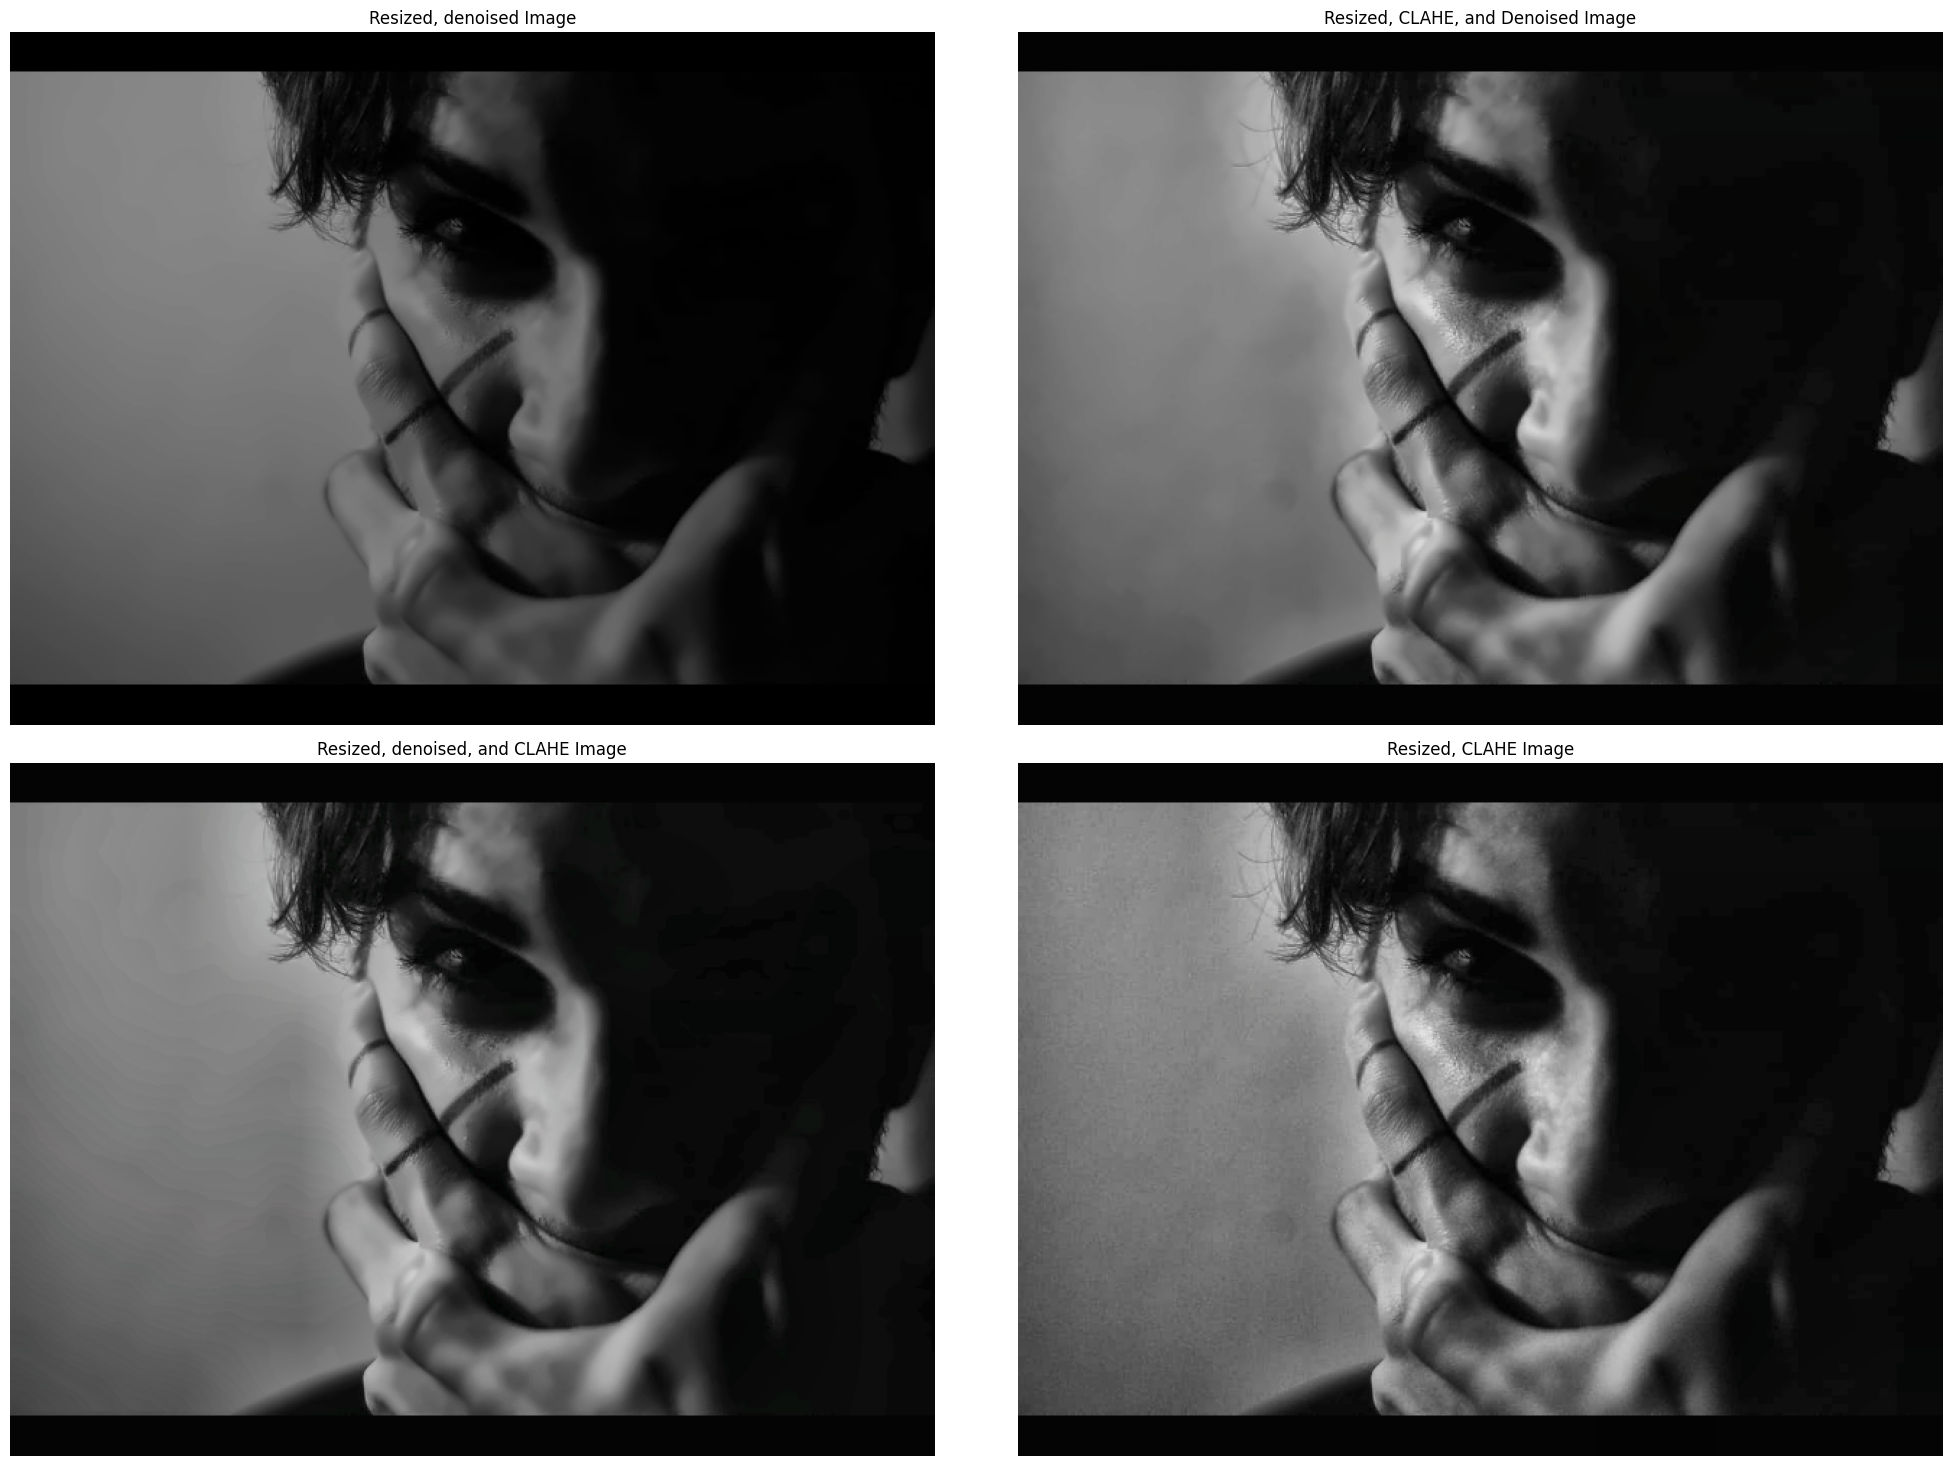

In [143]:
resized_image = resize_image(image, target_size)
denoised_image1 = denoise_image(resized_image)
clahe_image1 = apply_clahe_color(denoised_image1)
clahe_image2 = apply_clahe_color(resized_image)
denoised_image2 = denoise_image(clahe_image2)

plt.figure(figsize=(20, 15))

# Cách 1: Resized, denoised, and CLAHE images
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(denoised_image1, cv2.COLOR_BGR2RGB))
plt.title("Resized, denoised Image")
plt.axis('off')

# Cách 2: Resized, CLAHE, and denoised images
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(denoised_image2, cv2.COLOR_BGR2RGB))
plt.title("Resized, CLAHE, and Denoised Image")
plt.axis('off')

# Cách 3: Resized, denoised, and CLAHE images
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(clahe_image1, cv2.COLOR_BGR2RGB))
plt.title("Resized, denoised, and CLAHE Image")
plt.axis('off')

# Cách 4: Resized, CLAHE images
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(clahe_image2, cv2.COLOR_BGR2RGB))  
plt.title("Resized, CLAHE Image")
plt.tight_layout()
plt.axis('off')

plt.show()

**Kết luận**: 
    Thứ tự tối ưu nên là: `Resize → Denoise → CLAHE`

**Lý do:**

* Resize đầu tiên để chuẩn hóa kích thước, tránh tăng nhiễu/ảnh hưởng sai khi xử lý sau.
* Denoise kế tiếp làm sạch ảnh, giúp CLAHE xử lý chính xác vùng sáng/tối.
* CLAHE sau cùng để tối ưu độ tương phản mà không làm tăng nhiễu (do đã denoise rồi).




In [144]:
# List to store some sample of original and processed images
original_and_processed_images = []

In [145]:
def preprocess_image(input_folfer, output_folder, extensions, target_size):
    image_files = [f for f in os.listdir(input_folfer) if f.endswith(extensions)]
    
    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(input_folfer, image_file)
        output_path = os.path.join(output_folder, image_file)

        if os.path.exists(output_path):
            print(f"[INFO] {output_path} already exists, skipping...")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"[ERROR] Could not read {image_file}, skipping...")
            continue

        # Resize the image
        resized_image = resize_image(img, target_size)
        # Denoise the image
        denoised_image = denoise_image(resized_image)
        # Apply CLAHE
        clahe_image = apply_clahe_color(denoised_image)
        # Aply Unsharp Masking
        unsharp_image = unsharp_mask(clahe_image)

        # Save the processed image
        cv2.imwrite(output_path,  unsharp_image)
        print(f"[INFO] Processed {idx + 1}/{len(image_files)}: {image_file}")
        
        if len(original_and_processed_images) < 10:  # Store only the first 10 images
            original_and_processed_images.append((img, unsharp_image))


In [146]:
preprocess_image_folder = os.path.join(path, 'Data', 'preprocessed_images')

if not os.path.exists(preprocess_image_folder):
    os.makedirs(preprocess_image_folder)

preprocess_image(images_folder, preprocess_image_folder, ".jpg", target_size)

[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000136.jpg already exists, skipping...
[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000149.jpg already exists, skipping...
[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000151.jpg already exists, skipping...
[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000154.jpg already exists, skipping...
[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000164.jpg already exists, skipping...
[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000208.jpg already exists, skipping...
[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000308.jpg already exists, skipping...
[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000315.jpg already exists, skipping...
[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000321.jpg already exists, skipping...
[INFO] f:\Code\auto_ViVQA\Data\preprocessed_images\000000000332.jpg already exists, skipping...


In [147]:
for original, processed in original_and_processed_images:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image")
    plt.axis('off')

    plt.show()

### Data augmentation (for later use)

In [148]:
import random

def apply_geometric_transform(image, mode="random"):
    h, w = image.shape[:2]
    M = None

    if mode == "random":
        mode = random.choice(["flip", "rotate", "affine", "perspective", "translate"])

    if mode == "flip":
        flip_code = random.choice([-1, 0, 1])  # -1: cả hai, 0: dọc, 1: ngang
        transformed = cv2.flip(image, flip_code)

    elif mode == "rotate":
        angle = random.uniform(-30, 30)
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

    elif mode == "affine":
        pts1 = np.float32([[0,0], [w-1,0], [0,h-1]])
        pts2 = pts1 + np.random.randint(-50, 50, pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)

    elif mode == "perspective":
        margin = 0.1
        src = np.float32([
            [w * margin, h * margin],
            [w * (1 - margin), h * margin],
            [w * margin, h * (1 - margin)],
            [w * (1 - margin), h * (1 - margin)]
        ])
        dst = src + np.random.uniform(-w * 0.15, w * 0.15, src.shape).astype(np.float32)
        M = cv2.getPerspectiveTransform(src, dst)

    elif mode == "translate":
        tx = int(random.uniform(-0.3 * w, 0.3 * w))
        ty = int(random.uniform(-0.3 * h, 0.3 * h))
        M = np.float32([[1, 0, tx], [0, 1, ty]])

    else:
        raise ValueError(f"Unknown mode: {mode}")
    
    # borderMode: Cách xử lý phần biên khi pixel sau biến đổi nằm ngoài vùng ảnh gốc
    # cv2.BORDER_CONSTANT: đệm bằng giá trị cố định (như màu đen).
    # cv2.BORDER_REFLECT: phản chiếu biên (như gương).
    # cv2.BORDER_REPLICATE: lặp lại pixel gần nhất.
    # cv2.BORDER_WRAP: cuộn lại từ đầu (rất hiếm dùng).

    # flags: Cách nội suy pixel mới
    # cv2.INTER_LINEAR: nội suy tuyến tính (thường dùng cho ảnh).
    # cv2.INTER_NEAREST: nội suy gần nhất (nhanh nhưng có thể mất chi tiết).
    # cv2.INTER_CUBIC: nội suy bậc ba (chất lượng cao hơn, chậm hơn).
    # cv2.INTER_LANCZOS4: nội suy Lanczos (chất lượng cao, chậm nhất).

    # transformed = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    # transformed_image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    if mode == "flip":
        pass # Đã xử lý ở trên
    elif mode == "perspective":
        transformed = cv2.warpPerspective(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    else:
        transformed = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return transformed, mode


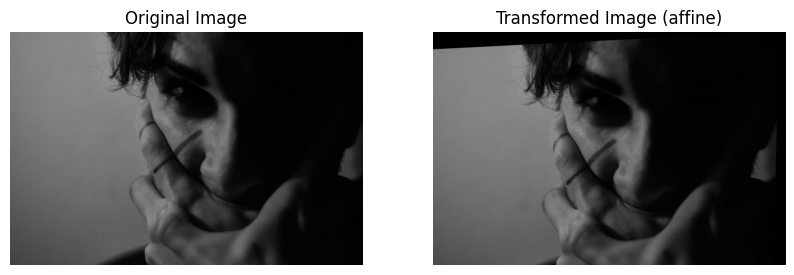

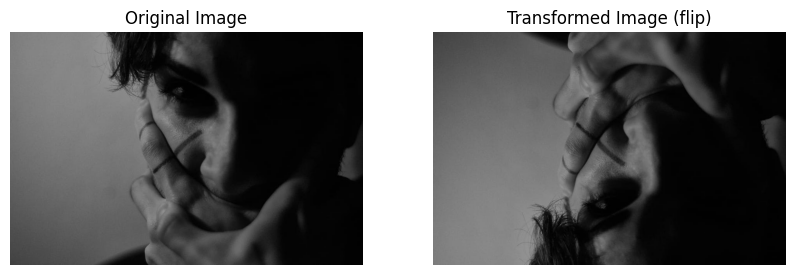

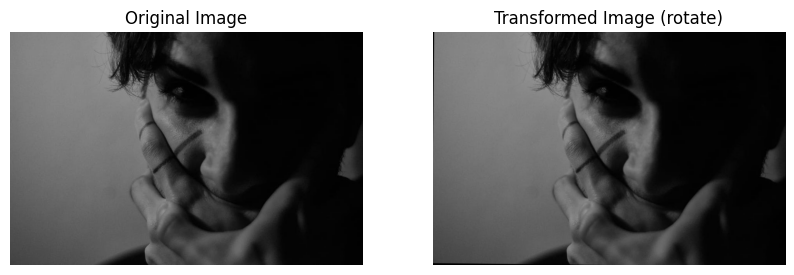

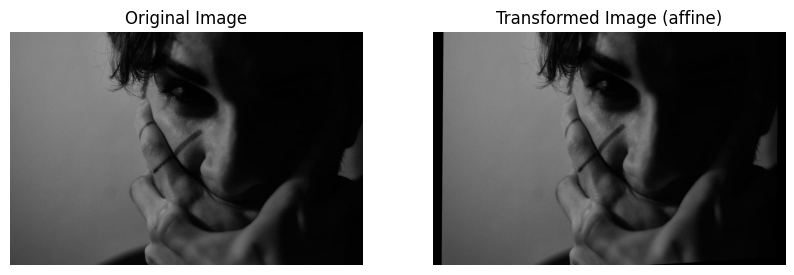

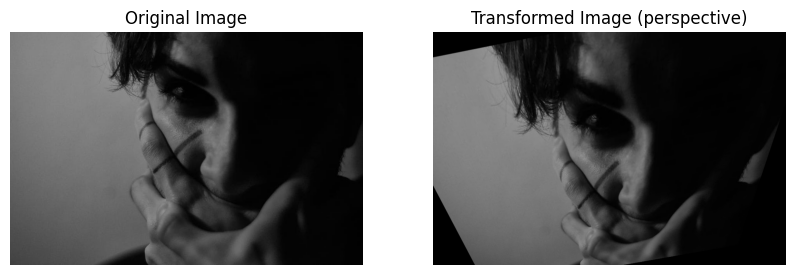

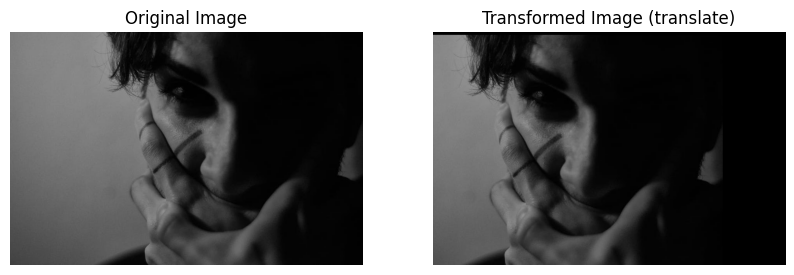

In [149]:
# TEST

for mode in ['random', 'flip', 'rotate', 'affine', 'perspective', 'translate']:

    transformed_image, transform_type = apply_geometric_transform(image, mode)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Transformed Image ({transform_type})")
    plt.axis('off')
    
    plt.show()